# Process optimization by genetic algorithm

10 same items scheduling

In [189]:
include("../../src/ProcGA.jl")

Main.ProcGA

In [144]:
using CSV
using DelimitedFiles
using DataFrames
using Missings
using Statistics

In [14]:
using Plots, Plotly

┌ Info: Precompiling Plotly [58dd65bb-95f3-509e-9936-c39a10fdeae7]
└ @ Base loading.jl:1192


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/ca093309b313bb1b910f847fbc5df50a50de9ece-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/ca093309b313bb1b910f847fbc5df50a50de9ece-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [164]:
gr()

Plots.GRBackend()

## reading data

In [16]:
ptbl = CSV.read("proctable.csv",header = 1);

In [17]:
# take smaller size 
ptbl = ptbl[1:10,:];

In [18]:
mtbl = convert(Array, ptbl[1:2])

10×2 Array{Any,2}:
 "BB105 間管"       50
 "BB201-3 3補助管2"  50
 "BH301M 間管"      50
 "BH301M 枝管1"     50
 "BH301M 枝管2"     50
 "EP201 間管"       50
 "EP201-2 2補助管"   50
 "EP201-2 枝管1"    50
 "HR567 枝管4"      50
 "HR567 枝管4C"     50

In [19]:
ptbl2 = [coalesce.(x,0) for x in convert(Array, ptbl[3:end])]

10×14 Array{Int64,2}:
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2
 1  0  0  0  0  0  3  0  2  0  0  2  2  2

In [20]:
s = string.(names(ptbl)[3:end])

14-element Array{String,1}:
 "pipecut"           
 "anneal_bs_prebend" 
 "anneal_ns_prebend" 
 "icing"             
 "rotbend"           
 "pressbend"         
 "anneal_bs_precalib"
 "anneal_ns_precalib"
 "vcalib"            
 "hcalib"            
 "buff_precut"       
 "mc_cut"            
 "buff_postcut"      
 "qc_check"          

In [21]:
nametable = DataFrame(id = 1:length(s), nm = s)

,id,nm
1,1,pipecut
2,2,anneal_bs_prebend
3,3,anneal_ns_prebend
4,4,icing
5,5,rotbend
6,6,pressbend
7,7,anneal_bs_precalib
8,8,anneal_ns_precalib
9,9,vcalib
10,10,hcalib


Read grouping info.

In [68]:
gtbl = readdlm("grouping.csv",',', skipstart = 1)

2×5 Array{Any,2}:
 "anneal_bs"  "[2;7]"  300  3  1
 "anneal_ns"  "[3;8]"  300  3  1

In [69]:
gtbl2=[]
for k in 1:size(gtbl)[1]
    x = gtbl[k, 2:end]
    push!(gtbl2,Dict(:id=>eval(Meta.parse(x[1])),:cnt=>x[2],:timespan=>x[3],:grp=>x[4]))
end

In [70]:
gtbl2

2-element Array{Any,1}:
 Dict{Symbol,Any}(:timespan=>3,:id=>[2, 7],:cnt=>300,:grp=>1)
 Dict{Symbol,Any}(:timespan=>3,:id=>[3, 8],:cnt=>300,:grp=>1)

## Initialize ProcGA tables.

In [190]:
ProcGA.settable(ptbl2, gtbl2, mtbl)

()

## Initialize population

In [191]:
savedfile = "bestprc.csv"

"bestprc.csv"

In [192]:
# create population from savedfile or make new
if isfile(savedfile)
    println("read from $savedfile")
    gbs = readdlm(savedfile, ',', Int)
else
    println("Read base data manually created from 6-same best practice.")
    g1 = ProcGA.jobtablebase()
    bs = readdlm("10same.csv",',',Int)
    ca = size(g1)[2]-size(bs)[2]
    gbs = hcat(bs,zeros(Int,(10,ca)))
end
gbs

read from bestprc.csv


10×120 Array{Int64,2}:
 1  7  7  7  0  0  0  0  0   9   9   0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  7  7  7  0  0   0   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  7  7  7  9  9  12  12  13     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  7  7   7   0   9     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0   0   7   7     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  7  7   7   0   0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  7  7   7   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0   0   7   7     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1   0   7   7     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   1   0   0     0  0  0  0  0  0  0  0  0  0  0  0

In [193]:
ProcGA.penalty(gbs)

69

Make population.
Half of it is from best data and latter half is randomly made.

In [210]:
ppl = ProcGA.initpopulationfrom(gbs,100);
ppl = vcat(ppl, ProcGA.initpopulation(100));

## Defining penalty functions

You can give your own penalty function when needed.

In [152]:
# ProcGA.penalty(jtbl) = mypenalty(jtbl)

In [217]:
# ProcGA.penalty(jtbl) = ProcGA.orgpenalty(jtbl)

In [250]:
function mypenalty(jtbl)
    p = ProcGA.validlength(jtbl)
    p += ProcGA.serpenalty(jtbl)
    p += ProcGA.grpenalty(jtbl)
    p += ProcGA.grdupenalty(jtbl)
    p += 2*ProcGA.dupenalty(jtbl) # weight
    p
end

ProcGA.penalty(jtbl) = mypenalty(jtbl)

## Evolution!

In [251]:
# first sort ppl by their penalties
ProcGA.sortpopulation!(ppl);

In [252]:
v = ProcGA.penalty.(ppl)

200-element Array{Int64,1}:
 106
 106
 106
 106
 106
 106
 106
 106
 106
 106
 106
 106
 106
   ⋮
 108
 108
 108
 108
 108
 108
 108
 108
 108
 108
 112
 140

In [220]:
vlst = [(minimum(v), median(v), maximum(v))]

1-element Array{Tuple{Int64,Float64,Int64},1}:
 (247, 253.0, 306)

In [ ]:
# Proceed generation
vl = ProcGA.evolution!(ppl, 200, 10);
vlst = vcat(vlst,vl);

i:10 => (106, 106.0, 162)
i:20 => (106, 106.0, 142)
i:30 => (101, 106.0, 160)
i:40 => (101, 101.0, 153)
i:50 => (100, 101.0, 153)
i:60 => (100, 100.0, 150)
i:70 => (99, 100.0, 139)
i:80 => (99, 100.0, 134)
i:90 => (98, 99.0, 133)
i:100 => (98, 99.0, 124)
i:110 => (98, 98.0, 134)
i:120 => (98, 98.0, 139)
i:130 => (98, 98.0, 132)
i:140 => (93, 98.0, 152)


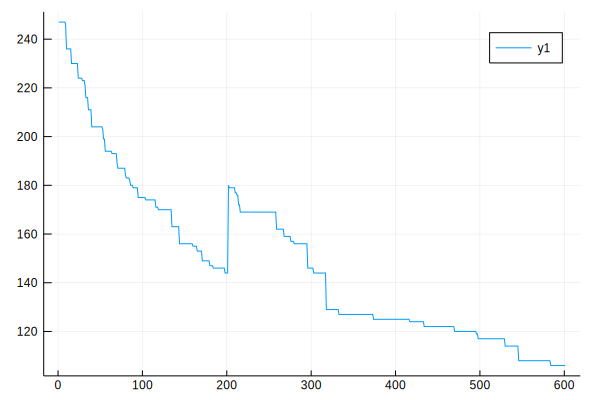

In [243]:
y = (x->x[1]).(vlst);
x = 1:length(y);

plot(x,y)

Pick up the best data.

In [244]:
v = ProcGA.penalty.(ppl)
idm = findmin(v)[2]
bestgen = ppl[idm]

10×120 Array{Int64,2}:
 1  7  7  7  0  0  0  0  0   9   9   0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   1   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  7  7  7  9  9  12  12  13     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  7  7   7   0   9     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0   0   7   7     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   0   0   0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   0   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   0   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   0   1   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   0   0   1     0  0  0  0  0  0  0  0  0  0  0  0

In [245]:
ProcGA.penalty(bestgen)

106

In [246]:
ProcGA.dupenalty(bestgen)

0

In [247]:
ProcGA.validlength(bestgen)

60

In [248]:
ProcGA.clipjob(bestgen)

10×60 Array{Int64,2}:
 1  7  7  7  0  0  0  0  0   9   9   0  …   0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0   1   0   0      0   0   0   0   0   0   0   0   0
 0  0  1  0  7  7  7  9  9  12  12  13      0   0   0   0   0   0   0   0   0
 0  0  0  1  0  0  0  7  7   7   0   9      0   0   0   0   0   0   0   0   0
 0  0  0  0  1  0  0  0  0   0   7   7      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0   0   0   0  …   0   0   0   0   0   0   0  14  14
 0  0  0  0  0  0  0  0  0   0   0   0      0  13  13  14  14   0   0   0   0
 0  0  0  0  0  0  0  0  0   0   0   0     13   0   0   0   0  14  14   0   0
 0  0  0  0  0  0  0  0  0   0   1   0      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0   0   0   1      0  14   0   0   0   0   0   0   0

Sort it by first appearance of process.

In [238]:
idx = zeros(Int,10)
for i in 1:10
    idx[i] = findfirst(x->(x>0),bestgen[i,:])
end
idx

10-element Array{Int64,1}:
  1
 10
  3
  4
  5
 13
 20
 15
 11
 28

In [239]:
id2 = sort(collect(1:10), by = x->idx[x])

10-element Array{Int64,1}:
  1
  3
  4
  5
  2
  9
  6
  8
  7
 10

In [240]:
bestgensort = similar(bestgen)
for i in 1:size(bestgen)[1]
    bestgensort[id2[i],:] = bestgen[i,:]
end
bestgensort

10×120 Array{Int64,2}:
 1  7  7  7  0  0  0  0  0   9   9   0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0   0   7   7     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   1   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  7  7  7  9  9  12  12  13     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  7  7   7   0   9     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   0   0   0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   0   1   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   0   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   0   0   0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0   0   0   0     0  0  0  0  0  0  0  0  0  0  0  0

In [241]:
# save best process table to file.
# do not clip it so that it can be used again
writedlm("bestprc.csv",bestgensort, ',')

## Conclusion

For given 10 same data with proctalbe below, the best combination is "bestgen" here.

Its length is 33.
Taking time unit as 1 hour and assuming job time as 7 hours/day, it needs almost 5 days to finish these materials.

In [140]:
transpose(ProcGA.proctable[1,:])

1×14 LinearAlgebra.Transpose{Int64,Array{Int64,1}}:
 1  0  0  0  0  0  3  0  2  0  0  2  2  2

In [141]:
ProcGA.clipjob(bestgen)

10×33 Array{Int64,2}:
 1  7  7  7  0  0  0  0  0   9   9   0  …   0   0   0   0   0   0   0   0   0
 0  1  0  0  7  7  7  0  0   0   0   0      0   0   0  14  14   0   0   0   0
 0  0  1  0  7  7  7  9  9  12  12  13      0   0   0   0   0   0   0   0   0
 0  0  0  1  0  0  0  7  7   7   0   9     14   0   0   0   0   0   0   0   0
 0  0  0  0  1  0  0  0  0   0   7   7      0  13  13   0   0  14  14   0   0
 0  0  0  0  0  1  0  7  7   7   0   0  …  13  14  14   0   0   0   0   0   0
 0  0  0  0  0  0  1  7  7   7   0   0     14   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  1  0   0   7   7      0   0   0  13  13   0   0  14  14
 0  0  0  0  0  0  0  0  1   0   7   7      0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0  0  0  0   1   0   0     12  13  13   0   0  14  14   0   0